In [1]:
import pandas as pd
import numpy as np

import pandasql as ps

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_excel('startup_train.xlsx')

In [3]:
df.shape

(848, 47)

In [4]:
df.head()

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,founded_at,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1/1/2007,...,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1/1/2000,...,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,3/18/2009,...,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1/1/2002,...,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,8/1/2010,...,c:65806,1,1,0,0,0,0,1.0000,1,closed


In [5]:
print(df.status.value_counts())

acquired    543
closed      305
Name: status, dtype: int64


# Data Cleaning and EDA

In [6]:
df['is_success'] = np.where(df['status'] == 'acquired', 1, 0)

In [7]:
def encode_dates(df, column):
    df = df.copy()
    df[column] = pd.to_datetime(df[column])
    df[column + '_year'] = df[column].apply(lambda x: x.year)
    df[column + '_month'] = df[column].apply(lambda x: x.month)
    df[column + '_day'] = df[column].apply(lambda x: x.day)
    df = df.drop(column, axis=1)
    return df

In [8]:
df = encode_dates(df, column='founded_at')

In [9]:
df = df.drop(['state_code','first_funding_at', 'last_funding_at',
               'Unnamed: 0','latitude','longitude','zip_code',
               'id','city','name','Unnamed: 6','object_id', 'state_code.1'
              ,'category_code', 'status', 'founded_at_day', 'founded_at_month'], axis = 1)

In [10]:
df.duplicated().sum()

1

In [11]:
df.drop_duplicates(inplace = True)

In [12]:
df.isnull().sum()

age_first_funding_year        0
age_last_funding_year         0
age_first_milestone_year    146
age_last_milestone_year     146
relationships                 0
funding_rounds                0
funding_total_usd             0
milestones                    0
is_CA                         0
is_NY                         0
is_MA                         0
is_TX                         0
is_otherstate                 0
is_software                   0
is_web                        0
is_mobile                     0
is_enterprise                 0
is_advertising                0
is_gamesvideo                 0
is_ecommerce                  0
is_biotech                    0
is_consulting                 0
is_othercategory              0
has_VC                        0
has_angel                     0
has_roundA                    0
has_roundB                    0
has_roundC                    0
has_roundD                    0
avg_participants              0
is_top500                     0
is_succe

In [13]:
df.dropna(inplace = True)

In [14]:
df.shape

(701, 33)

In [15]:
df.head()

,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,is_NY,...,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,is_success,founded_at_year
0,2.2493,3.0027,4.6685,6.7041,3,3,375000,3,1,0,...,0,1,0,0,0,0,1.0000,0,1,2007
1,5.1260,9.9973,7.0055,7.0055,9,4,40100000,1,1,0,...,1,0,0,1,1,1,4.7500,1,1,2000
2,1.0329,1.0329,1.4575,2.2055,5,1,2600000,2,1,0,...,0,0,1,0,0,0,4.0000,1,1,2009
3,3.1315,5.3151,6.0027,6.0027,5,3,40000000,1,1,0,...,0,0,0,1,1,1,3.3333,1,1,2002
4,0.0000,1.6685,0.0384,0.0384,2,2,1300000,1,1,0,...,1,1,0,0,0,0,1.0000,1,0,2010


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 701 entries, 0 to 847
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age_first_funding_year    701 non-null    float64
 1   age_last_funding_year     701 non-null    float64
 2   age_first_milestone_year  701 non-null    float64
 3   age_last_milestone_year   701 non-null    float64
 4   relationships             701 non-null    int64  
 5   funding_rounds            701 non-null    int64  
 6   funding_total_usd         701 non-null    int64  
 7   milestones                701 non-null    int64  
 8   is_CA                     701 non-null    int64  
 9   is_NY                     701 non-null    int64  
 10  is_MA                     701 non-null    int64  
 11  is_TX                     701 non-null    int64  
 12  is_otherstate             701 non-null    int64  
 13  is_software               701 non-null    int64  
 14  is_web    

In [17]:
df.describe()

,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,is_NY,...,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,is_success,founded_at_year
count,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,7.010000e+02,701.000000,701.000000,701.000000,...,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000
mean,1.989336,3.770160,3.048707,4.756646,8.542083,2.362340,2.702506e+07,2.215407,0.530670,0.121255,...,0.300999,0.285307,0.546362,0.406562,0.221113,0.102710,2.804562,0.824536,0.710414,2005.807418
std,2.286674,2.891765,2.981856,3.255155,7.457116,1.378387,2.170853e+08,1.149207,0.499415,0.326657,...,0.459020,0.451883,0.498201,0.491542,0.415293,0.303797,1.878198,0.380635,0.453894,3.395165
min,-9.046600,-9.046600,-14.169900,-3.882200,0.000000,1.000000,1.100000e+04,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1984.000000
25%,0.468500,1.586300,1.000000,2.337000,4.000000,1.000000,3.000000e+06,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000,1.000000,0.000000,2004.000000
50%,1.326000,3.249300,2.504100,4.427400,6.000000,2.000000,9.950000e+06,2.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.333300,1.000000,1.000000,2006.000000
75%,2.917800,5.232900,4.668500,6.753400,11.000000,3.000000,2.420000e+07,3.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.666700,1.000000,1.000000,2008.000000
max,21.895900,21.895900,24.684900,24.684900,63.000000,8.000000,5.700000e+09,8.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,1.000000,1.000000,2013.000000


# Find Correlation

In [18]:
df.corr()

,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,is_NY,...,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,is_success,founded_at_year
age_first_funding_year,1.000000,0.732957,0.598808,0.485138,-0.134585,-0.140730,0.058404,-0.249460,0.020860,-0.155099,...,0.187360,-0.330153,-0.279070,-0.053057,0.039320,0.140548,0.091418,0.073874,0.013044,-0.733720
age_last_funding_year,0.732957,1.000000,0.693532,0.643210,0.131933,0.426338,0.124972,-0.082695,0.022366,-0.162753,...,0.375831,-0.314784,-0.106216,0.285431,0.336378,0.350390,0.092929,0.197046,0.111258,-0.791139
age_first_milestone_year,0.598808,0.693532,1.000000,0.776275,0.254193,0.188429,0.062587,-0.042640,0.050773,-0.093412,...,0.115754,-0.271562,0.005714,0.206735,0.199918,0.253823,0.050081,0.164924,0.182588,-0.684841
age_last_milestone_year,0.485138,0.643210,0.776275,1.000000,0.351054,0.263740,0.093366,0.346277,0.078858,-0.094247,...,0.100590,-0.242955,0.099634,0.275979,0.272006,0.257123,0.075191,0.213872,0.284325,-0.683565
relationships,-0.134585,0.131933,0.254193,0.351054,1.000000,0.374462,0.094869,0.480784,0.113292,0.016962,...,0.000259,-0.105314,0.303923,0.281586,0.287836,0.238975,0.108019,0.212731,0.291241,-0.058728
funding_rounds,-0.140730,0.426338,0.188429,0.263740,0.374462,1.000000,0.111724,0.242855,-0.018242,0.016502,...,0.342172,0.040210,0.233459,0.446436,0.463777,0.340850,0.043314,0.232987,0.135986,-0.146245
funding_total_usd,0.058404,0.124972,0.062587,0.093366,0.094869,0.111724,1.000000,0.004682,-0.038791,-0.024184,...,0.008388,-0.060092,-0.032892,0.012076,0.034803,0.035711,0.042582,0.044989,0.030154,-0.065655
milestones,-0.249460,-0.082695,-0.042640,0.346277,0.480784,0.242855,0.004682,1.000000,0.027053,0.093960,...,-0.066216,0.076802,0.305656,0.196271,0.130544,0.006100,0.048433,0.142048,0.196442,0.091929
is_CA,0.020860,0.022366,0.050773,0.078858,0.113292,-0.018242,-0.038791,0.027053,1.000000,-0.394996,...,-0.087067,-0.064150,0.101932,0.103347,0.074018,0.073365,0.068105,0.077198,0.073899,-0.061807
is_NY,-0.155099,-0.162753,-0.093412,-0.094247,0.016962,0.016502,-0.024184,0.093960,-0.394996,1.000000,...,-0.043682,0.142740,0.031243,-0.076139,-0.050490,-0.053701,0.084707,-0.012473,0.044464,0.193691


In [19]:
df = df[['age_first_funding_year', 'age_last_funding_year', 
         'age_first_milestone_year','age_last_milestone_year',
         'milestones','relationships','funding_rounds', 'funding_total_usd',
           'is_CA', 'is_NY','is_MA', 'is_TX', 'is_otherstate',
           'is_software','is_web','is_mobile','is_enterprise','is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory',
           'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD',
           'avg_participants', 'is_top500','is_success', 'founded_at_year'
           ]]
df_corr = df.corr()
print(df_corr['is_success'].sort_values(ascending=False))

is_success                  1.000000
relationships               0.291241
age_last_milestone_year     0.284325
is_top500                   0.276018
milestones                  0.196442
avg_participants            0.186306
age_first_milestone_year    0.182588
has_roundB                  0.157080
has_roundA                  0.138425
funding_rounds              0.135986
has_roundD                  0.133129
has_roundC                  0.120394
age_last_funding_year       0.111258
is_CA                       0.073899
is_MA                       0.049859
is_enterprise               0.047092
is_NY                       0.044464
is_advertising              0.042181
is_biotech                  0.034398
is_consulting               0.034151
is_software                 0.033330
funding_total_usd           0.030154
age_first_funding_year      0.013044
is_othercategory            0.011425
is_web                     -0.012386
is_TX                      -0.020394
is_mobile                  -0.037852
h

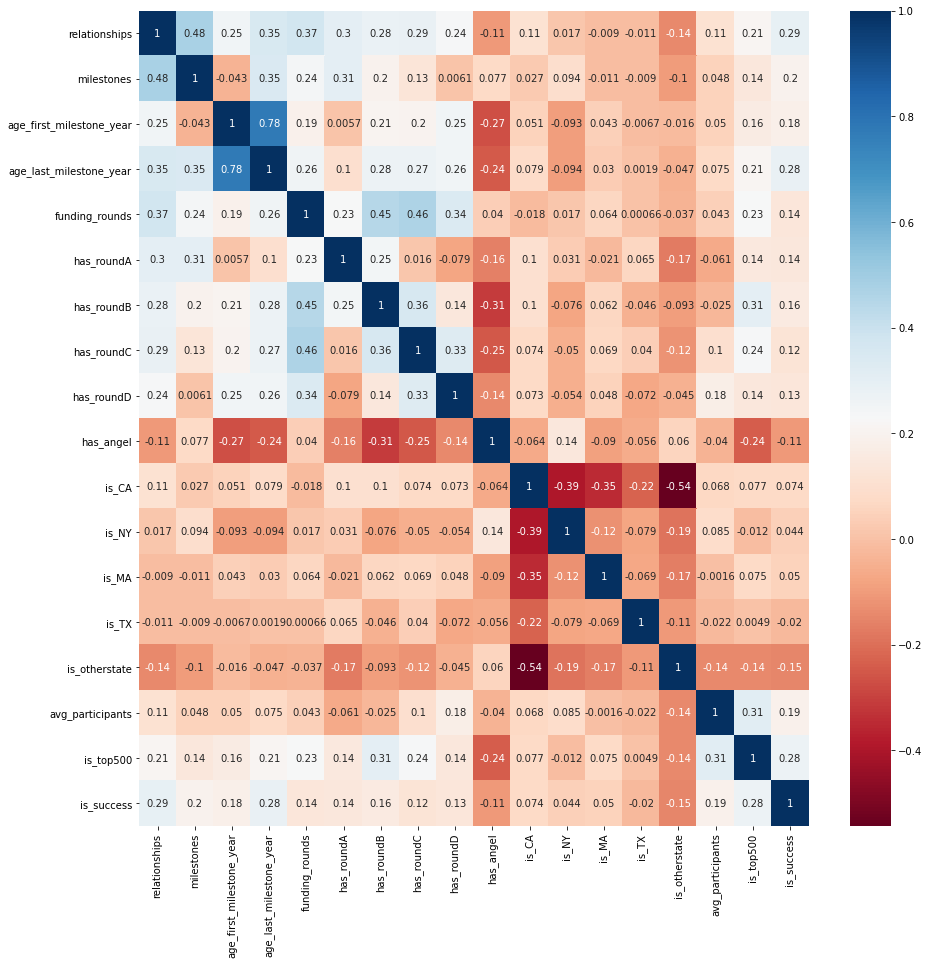

In [20]:
features = ['relationships','milestones',
            'age_first_milestone_year','age_last_milestone_year',
            'funding_rounds','has_roundA','has_roundB','has_roundC','has_roundD', 'has_angel',
            'is_CA','is_NY','is_MA', 'is_TX','is_otherstate',
            'avg_participants','is_top500','is_success']

plt.figure(figsize = (15,15))
sns.heatmap(df[features].corr(), annot = True, cmap = plt.cm.RdBu)
plt.show( )

In [21]:
df.head()

,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,milestones,relationships,funding_rounds,funding_total_usd,is_CA,is_NY,...,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,is_success,founded_at_year
0,2.2493,3.0027,4.6685,6.7041,3,3,3,375000,1,0,...,0,1,0,0,0,0,1.0000,0,1,2007
1,5.1260,9.9973,7.0055,7.0055,1,9,4,40100000,1,0,...,1,0,0,1,1,1,4.7500,1,1,2000
2,1.0329,1.0329,1.4575,2.2055,2,5,1,2600000,1,0,...,0,0,1,0,0,0,4.0000,1,1,2009
3,3.1315,5.3151,6.0027,6.0027,1,5,3,40000000,1,0,...,0,0,0,1,1,1,3.3333,1,1,2002
4,0.0000,1.6685,0.0384,0.0384,1,2,2,1300000,1,0,...,1,1,0,0,0,0,1.0000,1,0,2010


# Splitting Data

In [22]:
standardScaler = StandardScaler()
columns_to_scale = ['age_first_funding_year', 'age_last_funding_year',
                   'age_first_milestone_year','age_last_milestone_year',
                   'relationships','funding_rounds','funding_total_usd',
                    'milestones','avg_participants',
                    'founded_at_year']
df[columns_to_scale] = standardScaler.fit_transform(df[columns_to_scale])

In [23]:
y = df['is_success']
X = df.drop(['is_success'], axis = 1)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=1)

In [25]:
X_train

,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,milestones,relationships,funding_rounds,funding_total_usd,is_CA,is_NY,...,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,founded_at_year
754,-0.814224,-1.209869,-0.920187,-1.367991,-1.058360,-0.475333,-0.263060,-0.124529,0,1,...,0,0,1,0,0,0,0,-0.961481,0,1.530497
132,-0.608013,0.157297,-1.274145,-0.086062,-0.187573,0.061451,0.462944,-0.080787,1,0,...,0,0,0,1,1,1,0,-0.428675,1,0.056763
19,0.224094,-0.325314,0.013086,-0.388414,0.683213,0.598234,-0.263060,0.004494,1,0,...,0,0,0,1,1,0,0,-0.961481,1,0.351510
711,1.233615,0.359221,1.192724,0.604598,-0.187573,-0.609529,-0.989063,0.036763,1,0,...,0,0,0,0,0,0,1,0.104130,1,-0.532731
543,0.551396,-0.180247,0.264082,0.965083,0.683213,1.403409,-0.989063,-0.057738,1,0,...,0,0,0,0,0,1,0,3.300963,1,-0.827477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-0.178787,-0.757642,-0.267342,-0.683234,-0.187573,0.732430,-0.989063,-0.110750,0,0,...,0,0,0,1,0,0,0,-0.961481,0,0.351510
782,-0.878993,-0.994656,-0.666405,-1.135517,-1.058360,-0.609529,-0.263060,-0.124247,0,0,...,0,0,1,0,0,0,0,-0.961481,0,0.941003
86,-0.376595,-0.914060,-0.687548,-0.639426,-0.187573,-0.206941,-0.989063,-0.101531,1,0,...,0,0,0,1,0,0,0,-0.961481,1,0.056763
292,-0.431780,-0.957697,-0.632375,-0.364835,-0.187573,-0.877920,-0.989063,-0.101531,1,0,...,0,0,0,1,0,0,0,0.104130,0,-0.532731


In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        #print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        #print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        #print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        #print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

# Modeling the data

In [27]:
#Default Training: check which model has better accuracy
models = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbour": KNeighborsClassifier(), 
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

Logistic Regression trained.
K-Nearest Neighbour trained.
Decision Tree trained.
Random Forest trained.


In [28]:
for name, model in models.items():
    print(name + " Accuracy: {:.2f}%".format(model.score(X_test, y_test) * 100))

Logistic Regression Accuracy: 72.34%
K-Nearest Neighbour Accuracy: 75.89%
Decision Tree Accuracy: 70.21%
Random Forest Accuracy: 80.14%


# Logistic Regression

In [29]:
logisticR_clf = LogisticRegression(solver='liblinear')
logisticR_clf.fit(X_train, y_train)

print_score(logisticR_clf, X_train, y_train, X_test, y_test, train=True)
print_score(logisticR_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 77.32%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.661290    0.805046  0.773214    0.733168      0.762176
recall       0.491018    0.893130  0.773214    0.692074      0.773214
f1-score     0.563574    0.846803  0.773214    0.705189      0.762340
support    167.000000  393.000000  0.773214  560.000000    560.000000
_______________________________________________
Confusion Matrix: 
 [[ 82  85]
 [ 42 351]]

Test Result:
Accuracy Score: 70.92%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy   macro avg  weighted avg
precision   0.413793    0.785714   0.70922    0.599754      0.690756
recall      0.333333    0.838095   0.70922    0.585714      0.709220
f1-score    0.369231    0.811060   0.70922    0.590145      0.698252
support    36.000000  105.000000   0.70922  141.000000    141.00000

Tuning the Hyperparameter

In [30]:
params = {"C": np.logspace(-4, 4, 20),
          "solver": ["liblinear"]}

lr_clf = LogisticRegression()

lr_cv = GridSearchCV(lr_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=5, iid=True)
lr_cv.fit(X_train, y_train)
best_params = lr_cv.best_params_
print(f"Best parameters: {best_params}")
lr_clf = LogisticRegression(**best_params)

lr_clf.fit(X_train, y_train)

print_score(lr_clf, X_train, y_train, X_test, y_test, train=True)
print_score(lr_clf, X_train, y_train, X_test, y_test, train=False)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'C': 0.00026366508987303583, 'solver': 'liblinear'}
Train Result:
Accuracy Score: 76.79%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.803279    0.763527  0.767857    0.783403      0.775382
recall       0.293413    0.969466  0.767857    0.631439      0.767857
f1-score     0.429825    0.854260  0.767857    0.642042      0.727687
support    167.000000  393.000000  0.767857  560.000000    560.000000
_______________________________________________
Confusion Matrix: 
 [[ 49 118]
 [ 12 381]]

Test Result:
Accuracy Score: 75.89%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy   macro avg  weighted avg
precision   0.562500    0.784000  0.758865    0.673250      0.727447
recall      0.250000    0.933333  0.758865    0.591667      0.758865
f1-score    0.346154    0.852174  0.758865    0.599164      0.7229

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished
/Users/tanianatasyat/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


# K-Nearest Neighbor

In [31]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

print_score(knn_clf, X_train, y_train, X_test, y_test, train=True)
print_score(knn_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 82.86%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.838095    0.826374  0.828571    0.832234      0.829869
recall       0.526946    0.956743  0.828571    0.741845      0.828571
f1-score     0.647059    0.886792  0.828571    0.766926      0.815300
support    167.000000  393.000000  0.828571  560.000000    560.000000
_______________________________________________
Confusion Matrix: 
 [[ 88  79]
 [ 17 376]]

Test Result:
Accuracy Score: 75.89%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy   macro avg  weighted avg
precision   0.541667    0.803419  0.758865    0.672543      0.736588
recall      0.361111    0.895238  0.758865    0.628175      0.758865
f1-score    0.433333    0.846847  0.758865    0.640090      0.741269
support    36.000000  105.000000  0.758865  141.000000    141.00000

In [32]:
knn_clf = KNeighborsClassifier(n_neighbors=27)
knn_clf.fit(X_train, y_train)

print_score(knn_clf, X_train, y_train, X_test, y_test, train=True)
print_score(knn_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 77.32%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.756410    0.775934  0.773214    0.766172      0.770111
recall       0.353293    0.951654  0.773214    0.652474      0.773214
f1-score     0.481633    0.854857  0.773214    0.668245      0.743556
support    167.000000  393.000000  0.773214  560.000000    560.000000
_______________________________________________
Confusion Matrix: 
 [[ 59 108]
 [ 19 374]]

Test Result:
Accuracy Score: 75.89%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy   macro avg  weighted avg
precision   0.555556    0.788618  0.758865    0.672087      0.729113
recall      0.277778    0.923810  0.758865    0.600794      0.758865
f1-score    0.370370    0.850877  0.758865    0.610624      0.728195
support    36.000000  105.000000  0.758865  141.000000    141.00000

# Random Forest

In [33]:
rf_clf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_clf.fit(X_train, y_train)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    167.0  393.0       1.0      560.0         560.0
_______________________________________________
Confusion Matrix: 
 [[167   0]
 [  0 393]]

Test Result:
Accuracy Score: 78.72%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy   macro avg  weighted avg
precision   0.615385    0.826087  0.787234    0.720736      0.772291
recall      0.444444    0.904762  0.787234    0.674603      0.787234
f1-score    0.516129    0.863636  0.787234    0.689883      0.774911
support    36.000000  105.000000  0.787234  141.000000    141.000000
_______________________________________________
Conf

In [34]:
n_estimators = [500, 900, 1100, 1500]
max_features = ['auto', 'sqrt']
max_depth = [2, 3, 5, 10, 15, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

params_grid = {
    'n_estimators': n_estimators, 
    'max_features': max_features,
    'max_depth': max_depth, 
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
              }

rf_clf = RandomForestClassifier(random_state=42)
rf_cv = GridSearchCV(rf_clf, params_grid, scoring="accuracy", cv=3, verbose=1, n_jobs=-1)
rf_cv.fit(X_train, y_train)
best_params = rf_cv.best_params_
print(f"Best parameters: {best_params}")

rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train, y_train)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:  8.6min finished


Best parameters: {'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1500}
Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    167.0  393.0       1.0      560.0         560.0
_______________________________________________
Confusion Matrix: 
 [[167   0]
 [  0 393]]

Test Result:
Accuracy Score: 76.60%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy   macro avg  weighted avg
precision   0.555556    0.815789  0.765957    0.685673      0.749347
recall      0.416667    0.885714  0.765957    0.651190      0.765957
f1-score    0.476190    0.849315  0.765957    0.662753      0.

# Test the data

In [35]:
test_df = pd.read_excel("startup_test_new.xlsx")

In [36]:
test_df = encode_dates(test_df, column='founded_at')

In [37]:
test_df['founded_at_year'] = test_df['founded_at_year'].astype(int)

In [38]:
test_df = test_df.drop(['ID','founded_at_month','founded_at_day','state_code','first_funding_at', 'last_funding_at',
               'Unnamed: 0','latitude','longitude','zip_code',
               'id','city','name','Unnamed: 6','object_id', 'state_code.1'
              ,'category_code', 'status'], axis = 1)

In [39]:
test_df.isnull().sum()

age_first_funding_year      0
age_last_funding_year       0
age_first_milestone_year    6
age_last_milestone_year     6
relationships               0
funding_rounds              0
funding_total_usd           0
milestones                  0
is_CA                       0
is_NY                       0
is_MA                       0
is_TX                       0
is_otherstate               0
is_software                 0
is_web                      0
is_mobile                   0
is_enterprise               0
is_advertising              0
is_gamesvideo               0
is_ecommerce                0
is_biotech                  0
is_consulting               0
is_othercategory            0
has_VC                      0
has_angel                   0
has_roundA                  0
has_roundB                  0
has_roundC                  0
has_roundD                  0
avg_participants            0
is_top500                   0
founded_at_year             0
dtype: int64

In [40]:
test_df["age_first_milestone_year"].fillna(0, inplace = True)

In [41]:
test_df["age_last_milestone_year"].fillna(0, inplace = True)

In [42]:
testdf_pred = rf_clf.predict(test_df)

In [44]:
print(testdf_pred)

[0 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 0 1
 1 0 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 0 1 0 0 0 1 1
 1]


In [51]:
#Start the index from 1
num = test_df.index = np.arange(1, len(test_df)+1)

#Create the dataframe
test_df = pd.DataFrame({'ID': num, 'Status': testdf_pred})

In [50]:
testdf_pred = test_df['Status'].replace([0,1],['closed','acquired'])

In [53]:
#Save the data into csv file
test_df.to_csv("result.csv", index = False)

In [52]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      75 non-null     int64 
 1   Status  75 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.3+ KB
